<a href="https://colab.research.google.com/github/mcash8/DVBS2X-DNN-Implementation/blob/main/DNN_DVBS2X_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#to do 
#LSTM -- done
#use GPU for training -- (issues with input and model being on different devices)
#stack real and imaginary into one array -- (done)
#train --
#test -- 
#save output
#import back to matlab


In [1]:
#import libraries 
import numpy as np

#pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split

#for reading from csv
import csv 

#for plotting 
import matplotlib.pyplot as plt

In [78]:
#read input and labels into variables 
with open('train.csv', 'r') as f: 
    data = list(csv.reader(f, delimiter=","))

data = np.array(data, dtype = 'float32') #convert to numpy array
data = torch.from_numpy(data) #convert to torch tensor

with open('labels.csv', 'r') as f:
    labels = list(csv.reader(f, delimiter=","))

labels = np.array(labels, dtype = 'float32') #convert to numpy array
labels = torch.from_numpy(labels) #convert to torch tensor 

with open('test.csv', 'r') as f: 
    test = list(csv.reader(f, delimiter = ","))

test = np.array(test, dtype = 'float32') #convert to numpy array
test = torch.from_numpy(test) #convert to torch tensor

In [70]:
#create a custom dataset with input and labels 
class CustomDS(Dataset):
    def __init__(self, input, labels):
        self.labels = labels
        self.input = input

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.input[idx]
        return data, label

In [80]:
ds = CustomDS(data, labels) #create a dataset with (corrupted) input and corresponding labels
test_ds = CustomDS(test, test)  #create a test datset, ignore the repeated test variable. Will not be used
length = len(ds) 
train_size = int(0.7*length) 
val_size = int(0.3*length)

#get train, validation, and test sets
train_ds, val_ds = random_split(ds, [train_size, val_size])

#create data loaders
batch_size = 10; 
train_dl = DataLoader(train_ds, batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size, shuffle = True)
test_dl =DataLoader(test_ds, batch_size, shuffle = False)  #do not shuffle, very important

ValueError: ignored

In [72]:
#define NN
class Net(nn.Module):
    def __init__(self): 
    #layer definition here
        super().__init__()
        self.layers1 = nn.Sequential(
            #Conv1
            nn.Conv1d(1, 10, 1),
            nn.BatchNorm1d(10),
            nn.ReLU(),

            nn.Conv1d(10, 10, 1),
            nn.BatchNorm1d(10),
            nn.ReLU(),

            #Conv2
            nn.Conv1d(10, 20, 1),
            nn.BatchNorm1d(20),
            nn.ReLU(),

            nn.Conv1d(20, 20, 1),
            nn.BatchNorm1d(20),
            nn.ReLU(),
        )

        self.lstm1 = nn.LSTM(20, 10, 1, batch_first = True)
        self.lstm2 = nn.LSTM(10, 5, 1, batch_first = True)
        self.lstm3 = nn.LSTM(5, 10, 1, batch_first = True)
        self.lstm4 = nn.LSTM(10, 20, 1, batch_first = True)
        
        self.layers2 = nn.Sequential(
            #Conv3
            nn.Conv1d(20, 10, 1),
            nn.BatchNorm1d(10),
            nn.ReLU(),

            nn.Conv1d(10, 10, 1),
            nn.BatchNorm1d(10),
            nn.ReLU(),

            #Conv4
            nn.Conv1d(10, 1, 1)
        )   
       
    def forward(self, x): 
        x = torch.unsqueeze(x, 1) #need this so input is of size (N, Cin, L)
        #define hidden state and cell state

        #lstm1
        h_0 = torch.zeros(1, 10, 10) #(num_layers, batch_size, hidden_state)
        c_0 = torch.zeros(1, 10, 10)

        h_1 = torch.zeros(1,10, 5)
        c_1 = torch.zeros(1,10,5)

        h_2 = torch.zeros(1,10, 10)
        c_2 = torch.zeros(1, 10, 10)

        h_3 = torch.zeros(1, 10, 20)
        c_3 = torch.zeros(1, 10, 20)
        
        out = self.layers1(x) #convolution

        out = torch.reshape(out, (10, 100, 20))
        
        out, (h_n, c_n) = self.lstm1(out, (h_0, c_0)) #pass through lstm1 (h_n = [1,10,10])

        out,(h_n, c_n) = self.lstm2(out, (h_1, c_1))

        out,(h_n, c_n) = self.lstm3(out, (h_2, c_2))

        out, (h_n, c_n) = self.lstm4(out, (h_3, c_3))

        out = torch.reshape(out, (10, 20, 100))
    
        out = self.layers2(out) #convolution
        return out

    def training_step(self, x):
        inputs, labels = x #get input and labels from batch of data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        out = self(inputs) #forward pass
        loss = F.mse_loss(out, labels) #loss calculation
        return loss
    
    def validation_step(self, x):
        inputs, labels = x #get input and labels from batch of data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        out = self(inputs) #forward pass
        loss = F.mse_loss(out,labels) #loss calculation
        acc = 1-loss #accuracy calculation

        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs): 
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() #Co
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [73]:
def evaluate(model, val_dl):
    outputs = [model.validation_step(batch) for batch in val_dl]
    
    return model.validation_epoch_end(outputs)

In [74]:
def trainNet(epochs, lr, model, train_dl, val_dl, opt_func = torch.optim.SGD): 
    #training function for training NN
    #inputs: 
    #epochs: number of epochs to train for
    #lr: learning rate for optimizer
    #model: model to be traine on
    #train_dl: data loader with inputs and labels to train on
    #val_dl: validation loader 
    #opt_func: optimizer function

    optimizer = opt_func(model.parameters(), lr)
    history = [] #recording epoch-wise results

    for epoch in range(epochs):
    #enter training loop
        for batch in train_dl:
            loss = model.training_step(batch)
            loss.backward() #backprop
            optimizer.step() #step forward in optimizer based on backgrop results
            optimizer.zero_grad() #zero the gradients from training step

        #validation phase
        result = evaluate(model, val_dl)
        model.epoch_end(epoch, result)
        history.append(result)


    return history


In [75]:
net = Net() #instantiate 
if torch.cuda.is_available():
    net.cuda()

In [76]:
history = trainNet(10, 0.0001, net, train_dl, val_dl)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: Using a target size (torch.Size([10, 100])) that is different to the input size (torch.Size([10, 1, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: UserWarning: Using a target size (torch.Size([10, 100])) that is different to the input size (torch.Size([10, 1, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch [0], val_loss: 0.4430, val_acc: 0.5570
Epoch [1], val_loss: 0.4145, val_acc: 0.5855
Epoch [2], val_loss: 0.4058, val_acc: 0.5942
Epoch [3], val_loss: 0.4022, val_acc: 0.5978
Epoch [4], val_loss: 0.4002, val_acc: 0.5998
Epoch [5], val_loss: 0.3989, val_acc: 0.6011
Epoch [6], val_loss: 0.3980, val_acc: 0.6020
Epoch [7], val_loss: 0.3972, val_acc: 0.6028
Epoch [8], val_loss: 0.3964, val_acc: 0.6036
Epoch [9], val_loss: 0.3957, val_acc: 0.6043


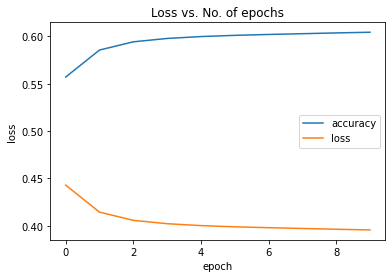

In [77]:
#plot training results
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, label = 'accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

losses = [result['val_loss'] for result in history]
plt.plot(losses, label = 'loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

plt.legend()

In [ ]:
#test on data and save 

out = net(input)

Debugging Section -- Ignore

In [ ]:
m = nn.Conv1d(16, 33, 3, stride=2)
input = torch.randn(20, 16, 50)
output = m(input)

n = nn.BatchNorm1d(33)
r = nn.ReLU()
output_batch = n(output)
out_relu = r(output_batch)



In [ ]:
print(input.shape)
print(output.shape)
print(output_batch.shape)
print(out_relu.shape)


torch.Size([20, 16, 50])
torch.Size([20, 33, 24])
torch.Size([20, 33, 24])
torch.Size([20, 33, 24])


In [ ]:
x = torch.randn(5,10)
x = torch.unsqueeze(x, 1)
print(x.shape)

torch.Size([5, 1, 10])


In [ ]:
#helper function for GPU
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
#helper function for moving tensors to GPU
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [27]:
if torch.cuda.is_available():
    print(True)

True


In [8]:
print(train_dl)

TypeError: ignored

In [21]:
t3 = torch.tensor([[5., 6], 
                   [7, 8], 
                   [9, 10]])
print(t3.shape)

torch.Size([3, 2])


In [22]:
# 3-dimensional array
t4 = torch.tensor([
    [[11, 12, 13], 
     [13, 14, 15]], 
    [[15, 16, 17], 
     [17, 18, 19.]]])
print(t4.shape)

torch.Size([2, 2, 3])


In [24]:
a = torch.zeros(10,20,100)
print(a.shape)

a = torch.reshape(a, (10,100,20))
print(a.shape)

torch.Size([10, 20, 100])
torch.Size([10, 100, 20])


In [20]:
rnn = nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))
print(output.shape)


h_n, c_n = rnn(input, (h0, c0))
print(h_n.shape)


torch.Size([5, 3, 20])
torch.Size([5, 3, 20])


In [ ]:
 '''
        self.layers2 = nn.Sequential(
            nn.Conv1d(20, 10, 1),
            nn.BatchNorm1d(10),
            nn.ReLU(),

            nn.Conv1d(10, 10, 1),
            nn.BatchNorm1d(10),
            nn.ReLU(),

            nn.Conv1d(10, 1, 1)

            
            nn.Conv1d(20, 20, 1),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            
        )
        '''

 #Conv2
            nn.Conv1d(10, 20, 1),
            nn.BatchNorm1d(20),
            nn.ReLU(),

            nn.Conv1d(20, 10, 1),
            nn.BatchNorm1d(10),
            nn.ReLU(),

            nn.Conv1d(10, 10, 1),
            nn.BatchNorm1d(10),
            nn.ReLU(),


